# Injecting a sequence of stimuli into a neuron

This notebook demonstrates how we can inject a stimulus with various amplitudes to a cell to compare cell responses.

BlueCelluLab automatically runs NEURON simulations in parallel on separate processes to enable process isolation.

**Note**: There always has to be a single NEURON simulation running on a process.

### Compiling the mechanisms

Before loading the cell, the cell mechanisms need to be compiled and provided. With NEURON installed, simply run the following command for the compilation.

In [1]:
!nrnivmodl ../mechanisms

/Users/tuncel/.virtualenvs/311-bluecellulab/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/tuncel/git_repositories/BlueCelluLab/examples/6-stimuli-sequence
Mod files: "../mechanisms/../mechanisms/Ca.mod" "../mechanisms/../mechanisms/CaDynamics_DC0.mod" "../mechanisms/../mechanisms/CaDynamics_E2.mod" "../mechanisms/../mechanisms/Ca_HVA.mod" "../mechanisms/../mechanisms/Ca_HVA2.mod" "../mechanisms/../mechanisms/Ca_LVAst.mod" "../mechanisms/../mechanisms/DetAMPANMDA.mod" "../mechanisms/../mechanisms/DetGABAAB.mod" "../mechanisms/../mechanisms/GluSynapse.mod" "../mechanisms/../mechanisms/Ih.mod" "../mechanisms/../mechanisms/Im.mod" "../mechanisms/../mechanisms/K_Pst.mod" "../mechanisms/../mechanisms/K_Tst.mod" "../mechanisms/../mechanisms/KdShu2007.mod" "../mechanisms/../mechanisms/NaTa_t.mod" "../mechanisms/../mechanisms/NaTg.mod" "../mech

In [2]:
from pathlib import Path
from bluecellulab.analysis.inject_sequence import apply_multiple_step_stimuli, StimulusName
from bluecellulab import EmodelProperties, Cell
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from matplotlib.pyplot import get_cmap

We will use the following function to plot the results.

In [3]:
import matplotlib.pyplot as plt

def plot_responses(responses):
    """Plot time vs voltage and time vs current for all stimuli."""
    plt.figure(figsize=(24, 8))

    # Font size settings
    title_fontsize = 16
    label_fontsize = 16
    tick_fontsize = 14
    legend_fontsize = 14

    # Create the left subplot for current
    plt.subplot(1, 2, 1)
    for stimulus, recording in responses.items():
        label_txt = stimulus.split(".")[1].title().replace("_", " ")
        plt.plot(recording.time, recording.current, label=label_txt, alpha=0.8)
    plt.legend(fontsize=legend_fontsize)
    plt.title('Injected Current', fontsize=title_fontsize)
    plt.xlabel('Time (ms)', fontsize=label_fontsize)
    plt.ylabel('Current (nA)', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    # Create the right subplot for voltage
    plt.subplot(1, 2, 2)
    for stimulus, recording in responses.items():
        label_txt = stimulus.split(".")[1].title().replace("_", " ")
        plt.plot(recording.time, recording.voltage, label=label_txt, alpha=0.8)
    plt.legend(fontsize=legend_fontsize)
    plt.title('Recorded Voltage', fontsize=title_fontsize)
    plt.xlabel('Time (ms)', fontsize=label_fontsize)
    plt.ylabel('Voltage (mV)', fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    return plt


### Loading the Neuron Model

We load the neuron model that we'll be using for our simulation. The neuron model is specified through a morphology file and a hoc file. The hoc file contains the NEURON code defining the neuron's physiology, while the morphology file defines the neuron's shape and structure. In this tutorial, we will use a Pyramidal neuron model.

In [4]:
# Define the base directory
base_dir = Path("../1-singlecell/")

# Define the hoc and morphology files
hoc_file = base_dir / "hoc" / "cADpyr_L2TPC.hoc"
morph_file = base_dir / "morphology" / "rr110330_C3_idA.asc"

emodel_properties = EmodelProperties(threshold_current=0.03203125,
                                     holding_current=-0.11,
                                     AIS_scaler=1.11)
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

The cell is loaded and its sections can be displayed as below.

In [5]:
# show 10 sections of dict
list(cell.sections.items())[:10]

[('soma[0]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].soma[0]),
 ('dend[0]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[0]),
 ('dend[1]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[1]),
 ('dend[2]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[2]),
 ('dend[3]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[3]),
 ('dend[4]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[4]),
 ('dend[5]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[5]),
 ('dend[6]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[6]),
 ('dend[7]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[7]),
 ('dend[8]', cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[8])]

### Applying multiple Fire Pattern Stimuli on our cell (neuron)

We will apply multiple Fire Pattern stimuli to our cell and compare the responses.

The amplitudes represent the percentage of threshold current that we will apply to the cell.

In other words, amplitude 120 means 120% of the cell's own threshold current will be injected to the cell.

In [6]:
amplitudes = [40, 60, 80, 100, 110, 120]
responses = apply_multiple_step_stimuli(cell, StimulusName.FIRE_PATTERN, amplitudes, section_name="soma[0]")

### Displaying the results

The 2 figures below show the current and voltage responses of the cell to the sequence of stimuli injected.

In [7]:
responses

{'StimulusName.FIRE_PATTERN_40': Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-65.        , -65.00180176, -65.00311997, ..., -85.13484436,
        -85.13484436, -85.13464564]), time=array([0.00000000e+00, 1.00275208e-03, 2.00550416e-03, ...,
        4.09900000e+03, 4.09900000e+03, 4.10000000e+03])),
 'StimulusName.FIRE_PATTERN_60': Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-65.        , -65.00180176, -65.00311997, ..., -85.13704606,
        -85.13704606, -85.13674786]), time=array([0.00000000e+00, 1.00275208e-03, 2.00550416e-03, ...,
        4.09900000e+03, 4.09900000e+03, 4.10000000e+03])),
 'StimulusName.FIRE_PATTERN_80': Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-65.        , -65.00180176, -65.00311997, ..., -85.13927918,
        -85.13927918, -85.13887698]), time=array([0.00000000e+00, 1.00275208e-03, 2.00550416e-03, ...,
        4.09900000e+03, 4.09900000e+03, 4.10000000e+03])),
 'StimulusName.FIRE

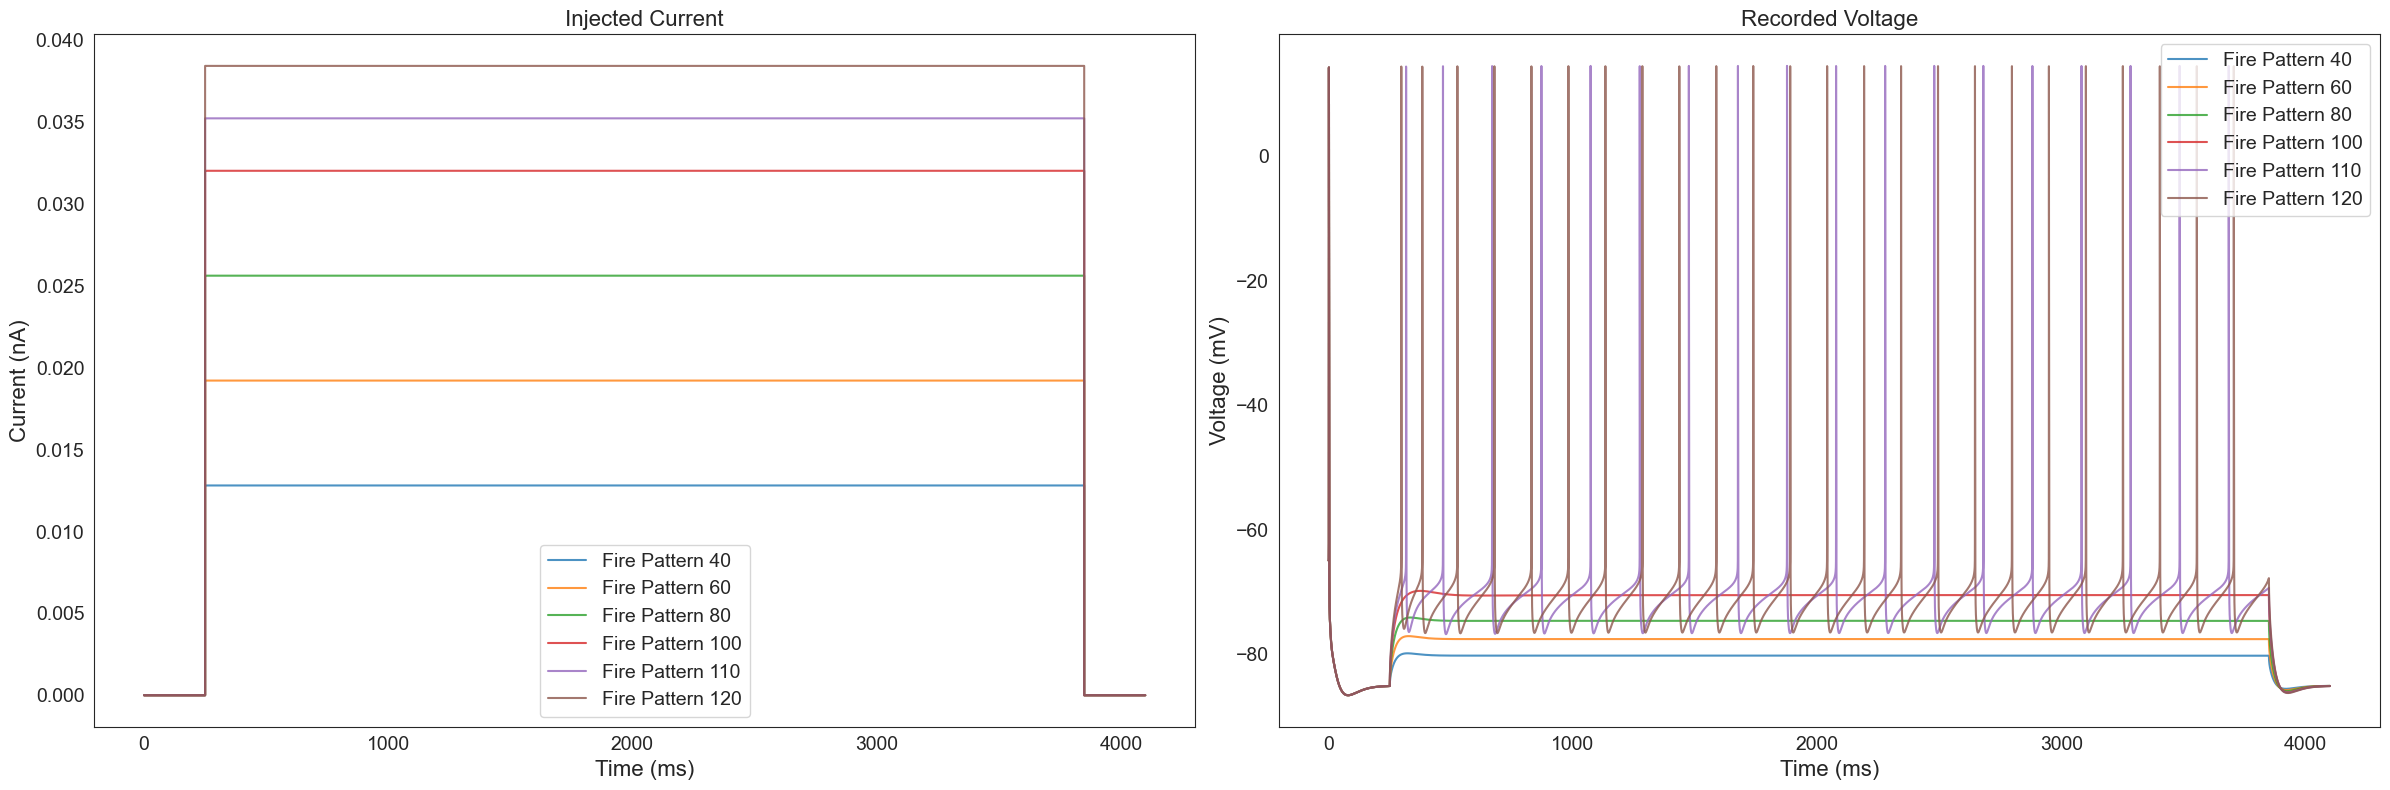

In [8]:
plt = plot_responses(responses)
plt.show()

### Applying multiple IV Stimuli on our cell (neuron)

Changing the type of the stimulus is as simple as changing the `stimulus_name` parameter in the `apply_multiple_step_stimuli` function.

In [9]:
amplitudes = [-20, -40, -60, -80]
iv_responses = apply_multiple_step_stimuli(cell, StimulusName.IV, amplitudes)

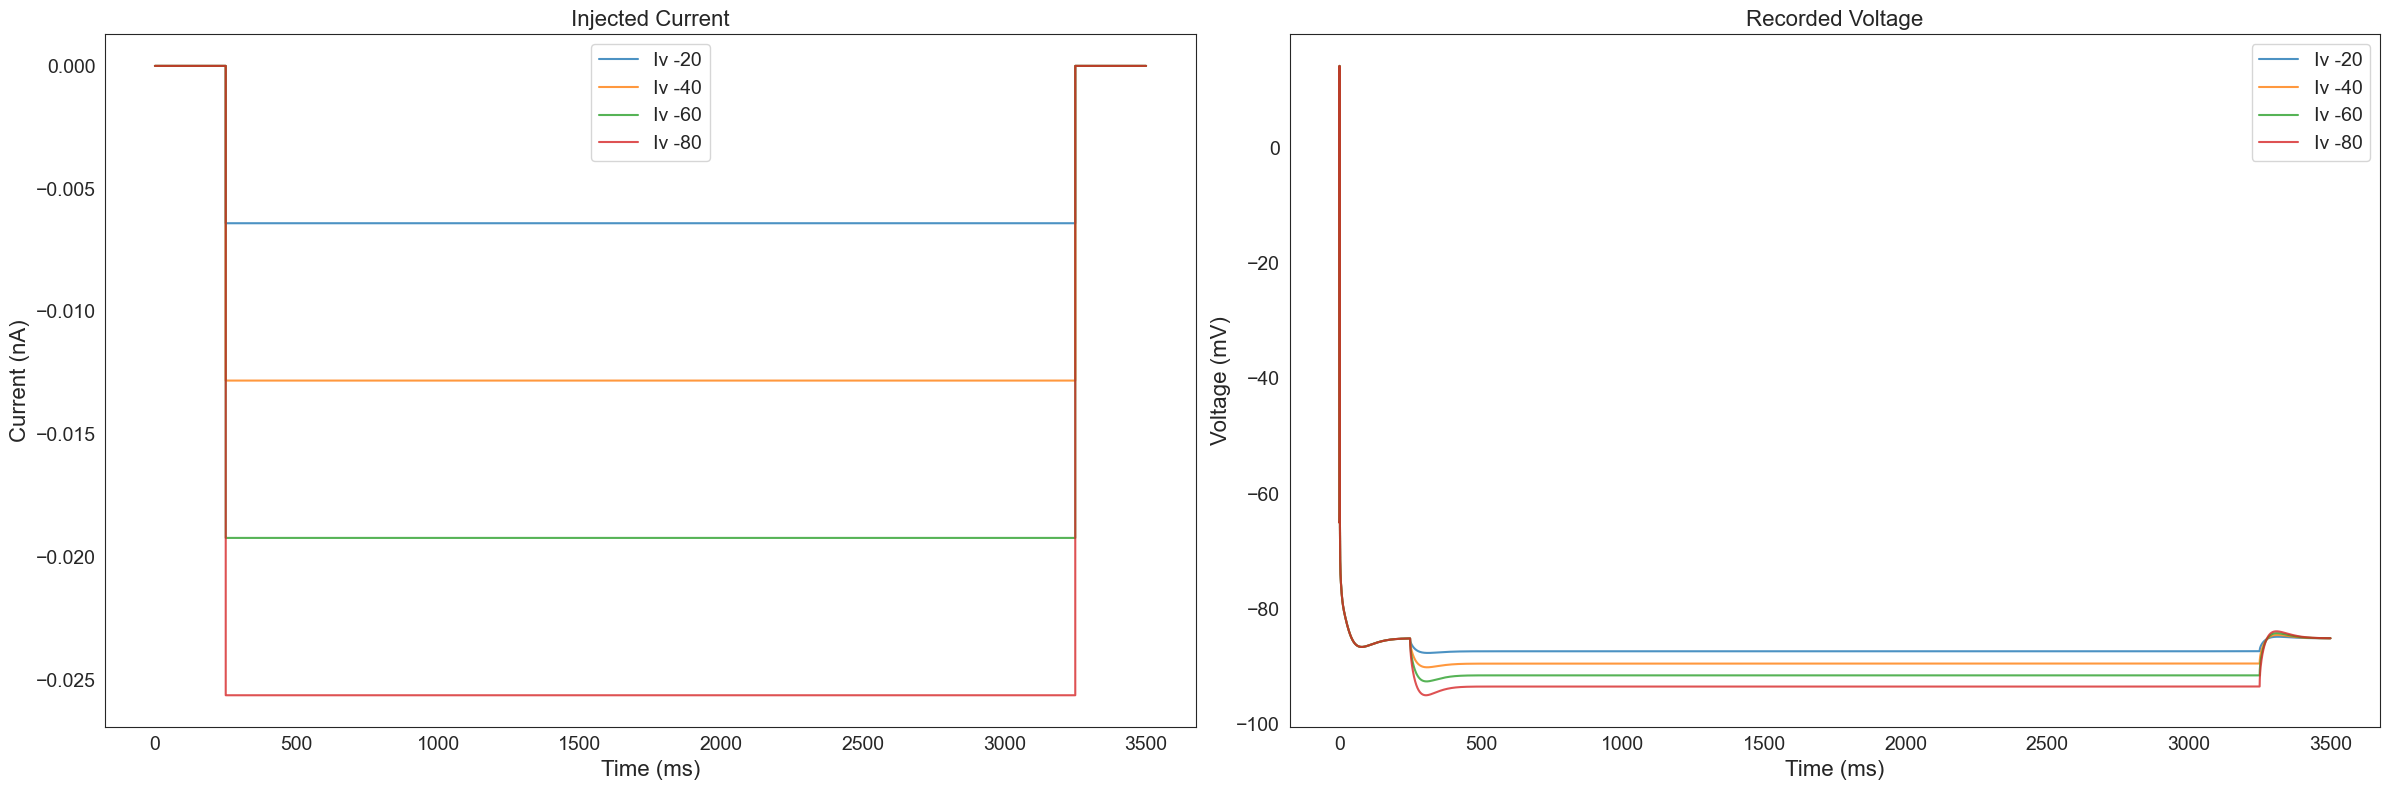

In [10]:
plt = plot_responses(iv_responses)
plt.show()

### Applying the IV stimuli on the dendrite of the cell

By default the stimuli are applied to the soma of the cell. We can also apply the stimuli to the dendrite of the cell by changing the `section_name` parameter in the `apply_multiple_step_stimuli` function.

Displaying the available sections within our cell.

In [11]:
cell.sections

{'soma[0]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].soma[0],
 'dend[0]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[0],
 'dend[1]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[1],
 'dend[2]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[2],
 'dend[3]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[3],
 'dend[4]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[4],
 'dend[5]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[5],
 'dend[6]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[6],
 'dend[7]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[7],
 'dend[8]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[8],
 'dend[9]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[9],
 'dend[10]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[10],
 'dend[11]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[11],
 'dend[12]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[12],
 'dend[13]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[13],
 'dend[14]': cADpyr_L2TPC_bluecellulab_0x1231e3bd0[0].dend[14]

In [12]:
amplitudes = [-20, -40, -60, -80]
iv_responses = apply_multiple_step_stimuli(cell, StimulusName.IV, amplitudes, section_name="dend[23]")

In [13]:
iv_responses["StimulusName.IV_-20"]

Recording(current=array([0., 0., 0., ..., 0., 0., 0.]), voltage=array([-65.        , -65.00067419, -65.00134836, ..., -84.56717378,
       -84.56717378, -84.56752657]), time=array([0.00000000e+00, 1.00275208e-03, 2.00550416e-03, ...,
       3.49900000e+03, 3.49900000e+03, 3.50000000e+03]))

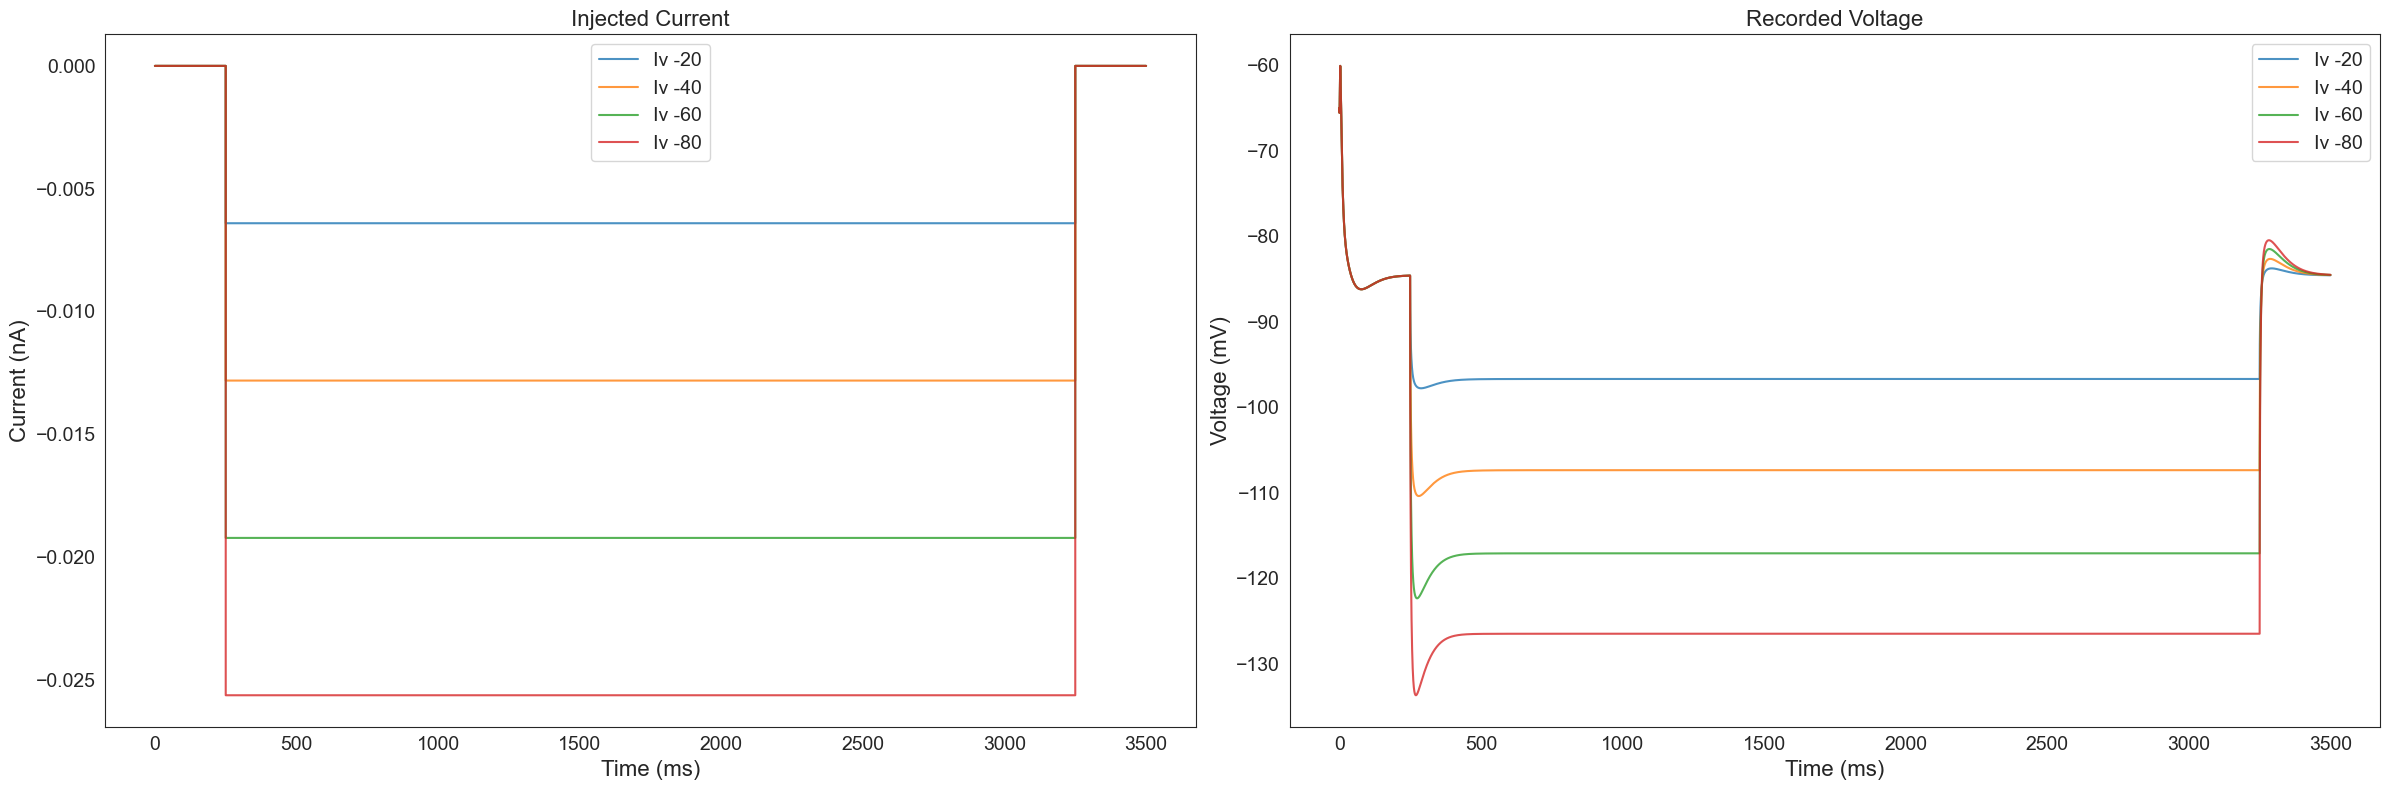

In [14]:
plt = plot_responses(iv_responses)
plt.show()

More information on the available stimuli can be found at the documentation: https://bluecellulab.readthedocs.io/en/latest/